In [1]:
import sys
import os

# # Go up two levels to reach the project root and add it to the path
sys.path.append(os.path.abspath("../"))

In [2]:
from src.loader.load_dataset_with_raw_signals import load_all_matfiles
df = load_all_matfiles(channels=['vibration_1'])

df.head()

Processing ../dataset/paderborn-db: 0it [00:00, ?it/s]
Processing ../dataset/paderborn-db/KA08:  54%|█████▍    | 43/80 [00:01<00:01, 34.80it/s]

Error loading ../dataset/paderborn-db/KA08/N15_M01_F10_KA08_2.mat: Expecting matrix here


Processing ../dataset/paderborn-db/KI04: 100%|██████████| 80/80 [00:02<00:00, 36.28it/s]

Skipped 1 files.


,bearing_id,torque_nm,speed_rpm,radial_force_n,label,vibration_1
0,KA01,0.7,1500,400,1,"[-0.2166748045443072, -0.16784667957657598, -0..."
1,KA01,0.7,900,1000,1,"[0.19226074206044158, -0.122070312419328, -0.4..."
2,KA01,0.7,1500,400,1,"[0.1770019530080256, -0.0244140624838656, -0.1..."
3,KA01,0.7,1500,400,1,"[-0.07629394526208, -0.0213623046733824, -0.14..."
4,KA01,0.7,1500,1000,1,"[0.4028320309837824, 0.39672851536281595, 0.40..."


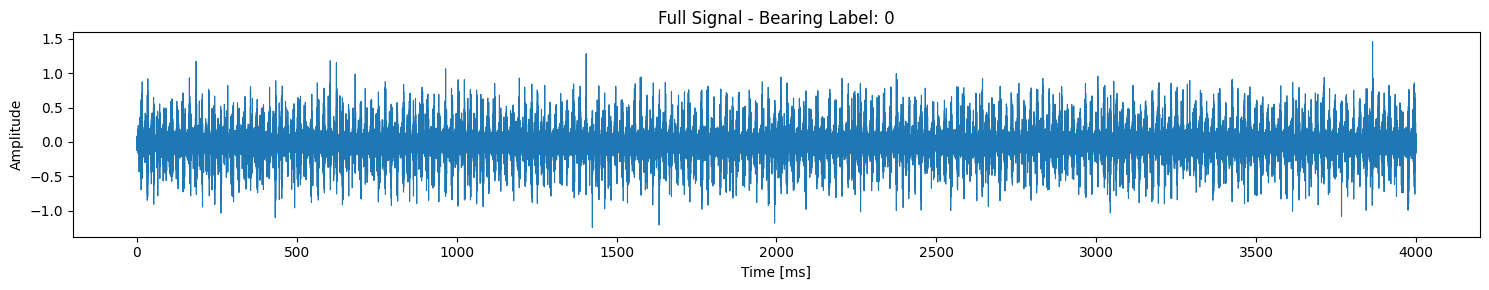

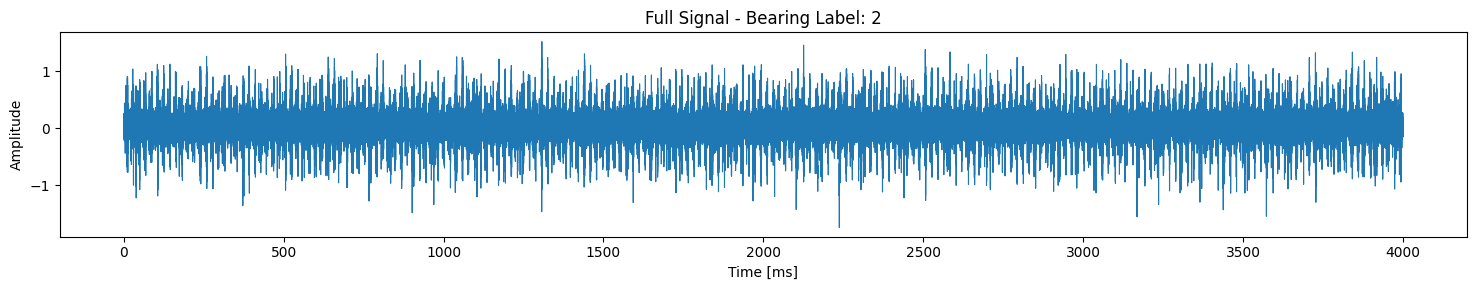

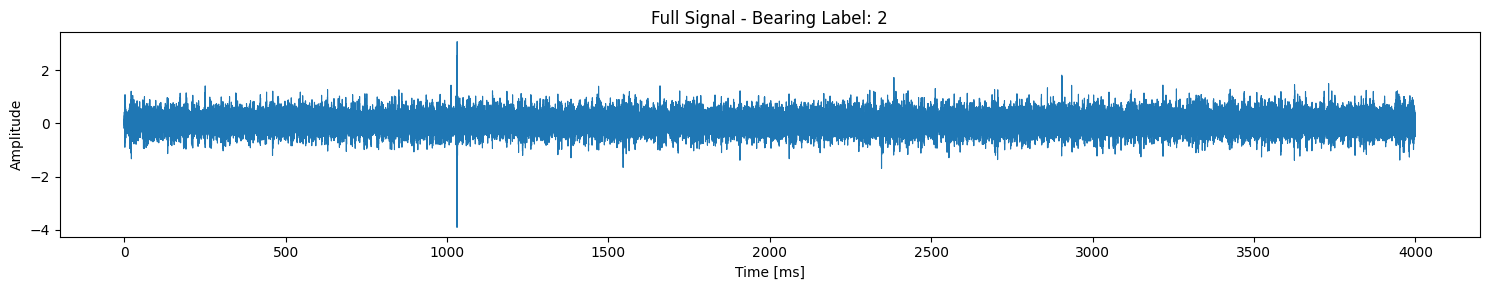

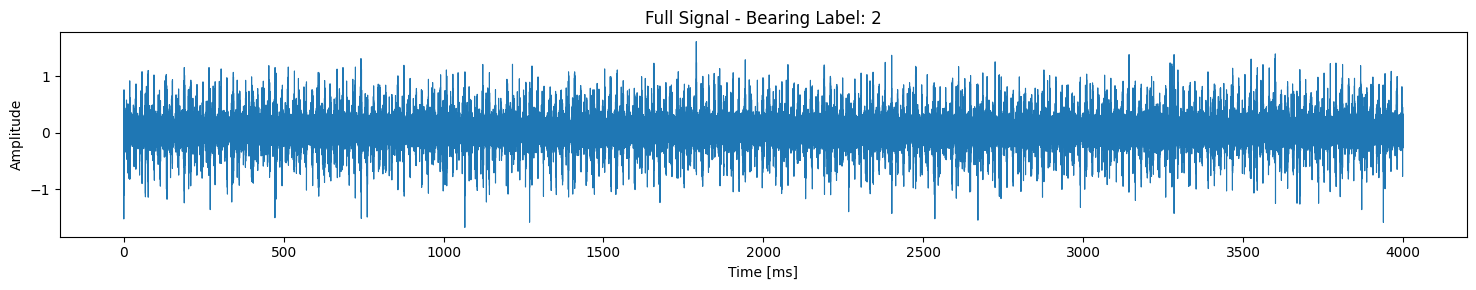

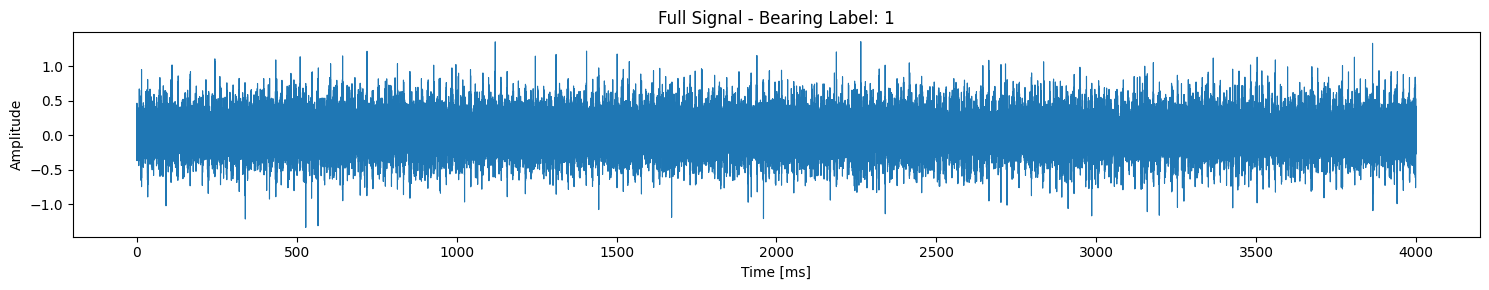

In [3]:
# Visualize a few signals with time domain plots
import random
import matplotlib.pyplot as plt
import numpy as np

# Sampling frequency for Paderborn dataset
fs = 64000  # 64 kHz

# Pick 5 random rows
random_rows = random.sample(range(len(df)), 5)

for row in random_rows:
    signal = df.iloc[row]['vibration_1']  # vibration column
    label = df.iloc[row]['label']         # bearing condition/fault label

    # Time axis in milliseconds
    time_ms = np.arange(len(signal)) / fs * 1000

    # Plot full signal
    plt.figure(figsize=(15, 3))
    plt.plot(time_ms, signal, linewidth=0.8)
    plt.xlabel('Time [ms]')
    plt.ylabel('Amplitude')
    plt.title(f'Full Signal - Bearing Label: {label}')
    plt.tight_layout()
    plt.show()
    plt.close()


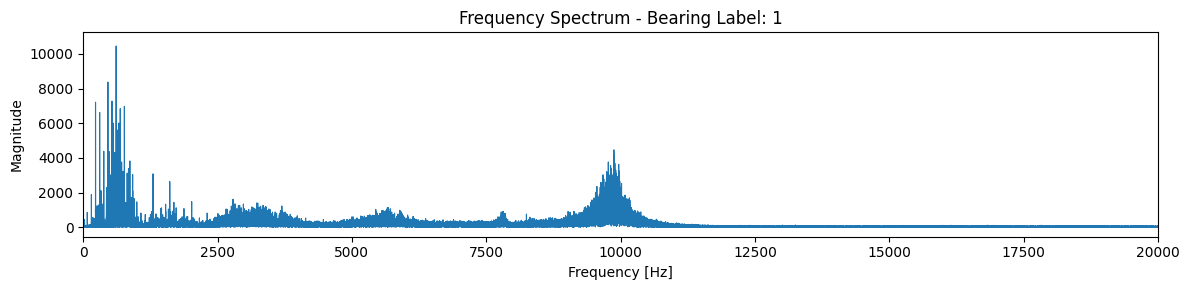

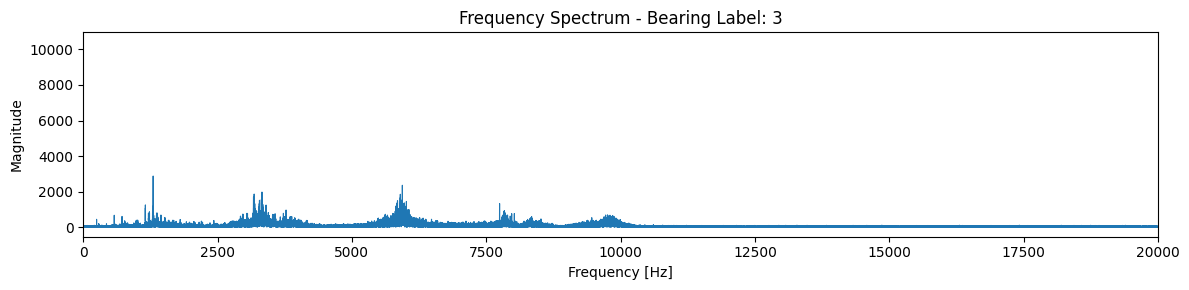

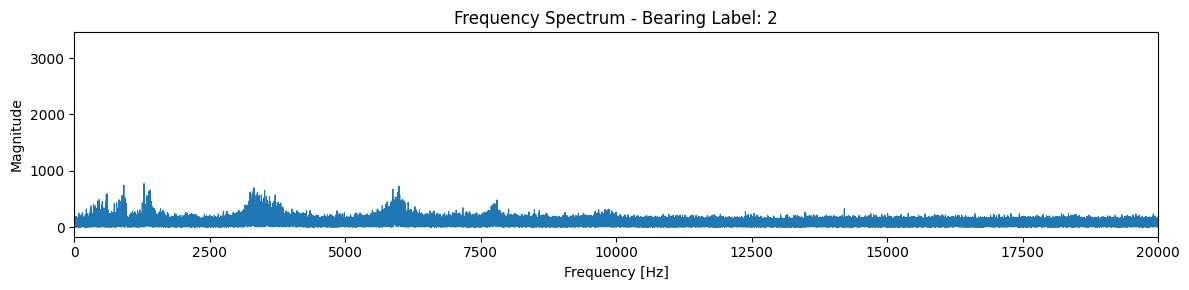

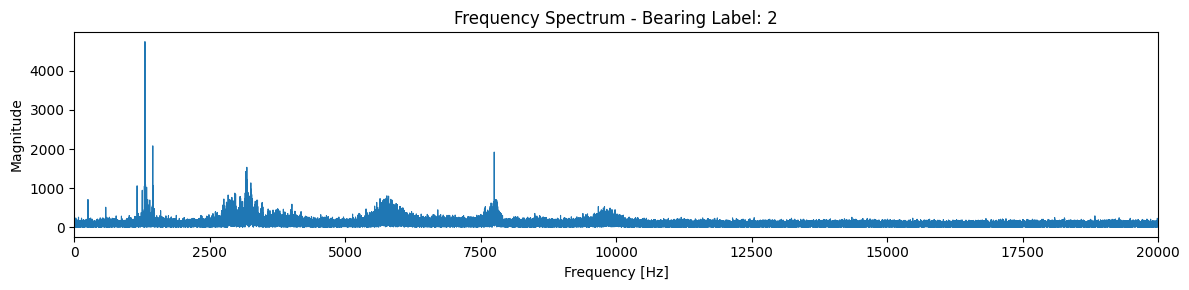

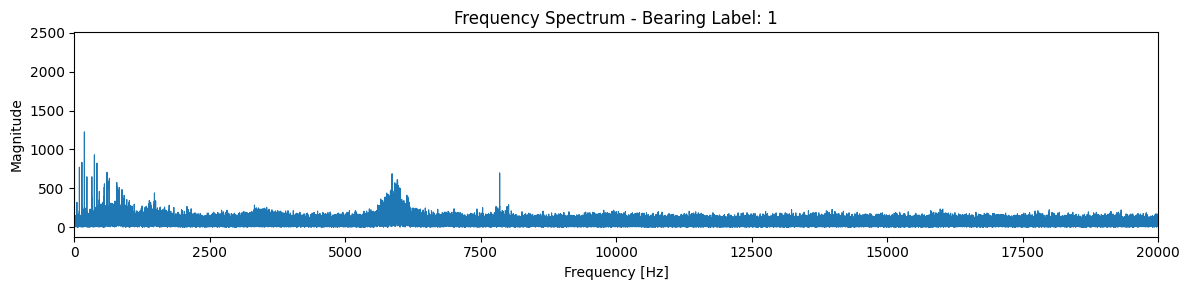

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Sampling frequency
fs = 64000  # 64 kHz

# Pick 5 random rows
random_rows = random.sample(range(len(df)), 5)

for row in random_rows:
    signal = df.iloc[row]['vibration_1']  # vibration column
    label = df.iloc[row]['label']         # bearing label column

    # FFT
    n = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_vals = np.abs(fft_vals[:n//2])       # positive frequencies only
    freqs = np.fft.fftfreq(n, 1/fs)[:n//2]   # corresponding frequency values

    # Plot
    plt.figure(figsize=(12, 3))
    plt.plot(freqs, fft_vals, linewidth=0.8)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Spectrum - Bearing Label: {label}')
    plt.xlim(0, 20000)  # optional: zoom into 0-20 kHz for clarity
    plt.tight_layout()
    plt.show()
    plt.close()


In [5]:
df.head()

,bearing_id,torque_nm,speed_rpm,radial_force_n,label,vibration_1
0,KA01,0.7,1500,400,1,"[-0.2166748045443072, -0.16784667957657598, -0..."
1,KA01,0.7,900,1000,1,"[0.19226074206044158, -0.122070312419328, -0.4..."
2,KA01,0.7,1500,400,1,"[0.1770019530080256, -0.0244140624838656, -0.1..."
3,KA01,0.7,1500,400,1,"[-0.07629394526208, -0.0213623046733824, -0.14..."
4,KA01,0.7,1500,1000,1,"[0.4028320309837824, 0.39672851536281595, 0.40..."


In [6]:
# Signal Data Information
fs = 64000
new_sample_length = 0.5  # 0.5  seconds
window_size = int(new_sample_length * fs)
window_stride = window_size // 2  # 50% overlap

In [7]:
classes = df['label'].unique()
print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: [1 3 2 0]
Number of classes: 4


In [8]:
# Split df to train and test
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (2047, 6)
Test shape: (512, 6)


In [9]:
# split signals to segments

def split_signal(signal, window_size, window_stride):
    segments = []
    num_segments = (len(signal) - window_size) // window_stride + 1
    for i in range(num_segments):
        start = i * window_stride
        end = start + window_size
        segment = signal[start:end]
        # float32
        segment = segment.astype(np.float16)
        # downsampling
        segment = segment[::20]
        segments.append(segment)
    return segments

def create_new_segments(df):
    X_segments = []
    y_labels = []
    idx_segments = []
    for index, row in df.iterrows():
        signal = row['vibration_1']
        # normalize signal
        signal = (signal - np.mean(signal)) / np.std(signal)
        segments = split_signal(signal, window_size, window_stride)
        X_segments.extend(segments)
        y_labels.extend([row['label']] * len(segments))
        idx_segments.extend([index] * len(segments))
    return X_segments, y_labels, idx_segments


In [10]:
# Create new segments

X_train, y_train, idx_train = create_new_segments(df_train)
X_test, y_test, idx_test = create_new_segments(df_test)

print("X_train shape:", len(X_train))
print("y_train shape:", len(y_train))
print("X_test shape:", len(X_test))
print("y_test shape:", len(y_test))

X_train shape: 30705
y_train shape: 30705
X_test shape: 7683
y_test shape: 7683


In [11]:
import pandas as pd
X_train = np.array(X_train)
X_test = np.array(X_test)

train_lengths = [len(x) for x in X_train]
test_lengths = [len(x) for x in X_test]

# Value counts
train_counts = pd.Series(train_lengths).value_counts()
test_counts = pd.Series(test_lengths).value_counts()

print("Train counts:\n", train_counts)
print("Test counts:\n", test_counts)

Train counts:
 1600    30705
Name: count, dtype: int64
Test counts:
 1600    7683
Name: count, dtype: int64


In [12]:
# Add dimension to signals
X_train = np.stack(X_train)
X_test  = np.stack(X_test)
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (30705, 1600, 1)
X_test shape: (7683, 1600, 1)


In [18]:
from src.models.simple_1d_cnn import Simple1DCNNModel

model = Simple1DCNNModel(num_classes=len(classes), input_shape=X_train.shape[1:])

history = model.train(X_train, np.array(y_train), epochs=50, batch_size=32)


Epoch 1/50


2026-02-19 05:00:41.767638: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157209600 exceeds 10% of free system memory.


768/768 [==============================] - ETA: 0s - loss: 1.1310 - accuracy: 0.4458

2026-02-19 05:01:55.589266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39302400 exceeds 10% of free system memory.


768/768 [==============================] - 79s 102ms/step - loss: 1.1310 - accuracy: 0.4458 - val_loss: 1.0447 - val_accuracy: 0.5309
Epoch 2/50
768/768 [==============================] - 75s 97ms/step - loss: 0.9907 - accuracy: 0.5570 - val_loss: 0.9447 - val_accuracy: 0.5979
Epoch 3/50
768/768 [==============================] - 120s 157ms/step - loss: 0.9016 - accuracy: 0.5986 - val_loss: 0.8712 - val_accuracy: 0.6209
Epoch 4/50
768/768 [==============================] - 120s 156ms/step - loss: 0.8502 - accuracy: 0.6193 - val_loss: 0.8411 - val_accuracy: 0.6351
Epoch 5/50
768/768 [==============================] - 105s 137ms/step - loss: 0.8157 - accuracy: 0.6342 - val_loss: 0.8664 - val_accuracy: 0.6251
Epoch 6/50
768/768 [==============================] - 111s 145ms/step - loss: 0.7811 - accuracy: 0.6470 - val_loss: 0.7747 - val_accuracy: 0.6530
Epoch 7/50
768/768 [==============================] - 107s 139ms/step - loss: 0.7540 - accuracy: 0.6624 - val_loss: 0.7814 - val_accuracy:

In [19]:
# save model
model.save("../exports/models/simple_1d_cnn.h5")


/home/samirshrestha/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Performance metrics for y_pred
y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred, axis=1)

# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_max))

241/241 [==============================] - 5s 22ms/step
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1605
           1       0.68      0.89      0.77      2817
           2       0.81      0.60      0.69      2676
           3       0.93      0.78      0.85       585

    accuracy                           0.76      7683
   macro avg       0.81      0.76      0.77      7683
weighted avg       0.77      0.76      0.75      7683



In [21]:
# Cohen's Kappa Score
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, y_pred_max)


0.6450477199045292

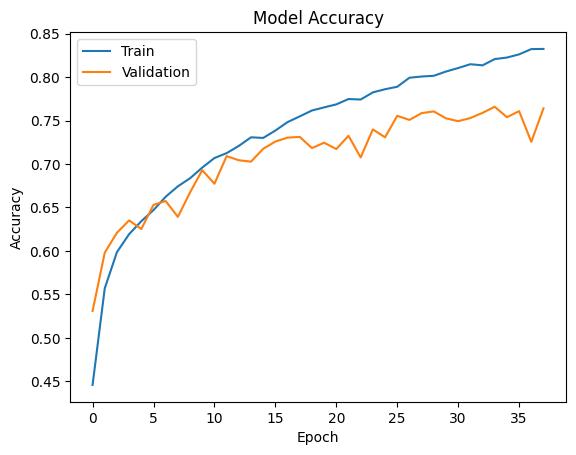

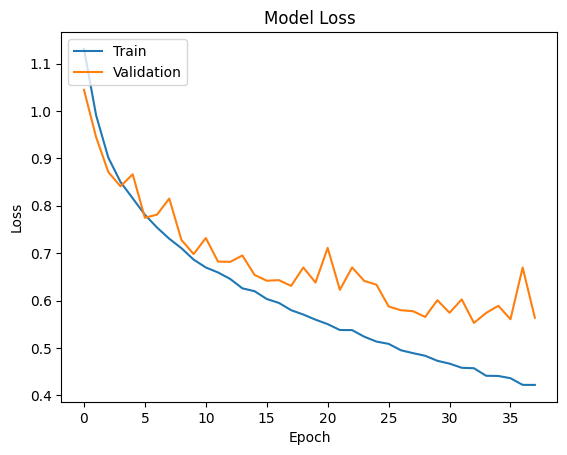

In [22]:
# Visualize history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()